# Article Recommendations with IBM

In this notebook, I will build out different recommendation systems for articles using real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

Let's get started by importing the necessary libraries and reading in the data.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to view data
print(df.shape)
df.head()

(45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Show df_content to view data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Using the dictionary and cells below, we provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  
 A visual and descriptive statistics will assist with giving a look at the number of times each user interacts with an article.  

In [6]:
#First, let's see the total number of unique users and articles we have
unique_users = df.nunique().email
print('{} unique users'.format(unique_users))

unique_articles = df.nunique().article_id
print('{} unique articles'.format(unique_articles))

5148 unique users
714 unique articles


In [7]:
# How many articles a user interacts with in the dataset
articles_per_user = df.groupby(['email']).count()['article_id']
articles_per_user.sort_values(ascending = False).head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

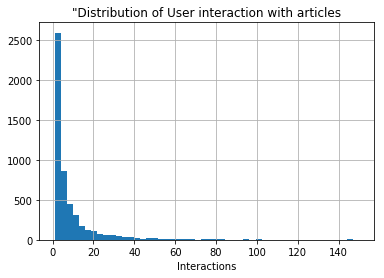

In [8]:
#Distribution plot of articles viewed per user
articles_per_user.hist(bins = 50, range = (1, 150));
plt.legend();
plt.xlabel('Interactions');
plt.title('"Distribution of User interaction with articles');

Most users interacted with 40 articles or less. 

In [9]:
#Average number of articles viewed per user
avg_articles_user = round(articles_per_user.mean(),2)
print('Average Number of articles a user interacted with:  {}'.format(avg_articles_user))

#Median article viewed per user
median_val = articles_per_user.median()
print('50% users interacted with {} articles or less'.format(median_val))

Average Number of articles a user interacted with:  8.93
50% users interacted with 3.0 articles or less


In [10]:
#Top 10 users on IBM Watson Studio Platform
top10_users = articles_per_user.sort_values(ascending = False).head(10)
print('Top 10 Users with highest Interactions:\n', top10_users)
print('\n')

#Top 10 articles interacted with
top10_articles = df.groupby(['title', 'article_id']).count()['email'].sort_values(ascending = False).reset_index(name = 'User_Count').head(10)
print('Top 10 articles users interacted with\n')
top10_articles.head(10)

Top 10 Users with highest Interactions:
 email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
Name: article_id, dtype: int64


Top 10 articles users interacted with



,title,article_id,User_Count
0,use deep learning for image classification,1429.0,937
1,insights from new york car accident reports,1330.0,927
2,visualize car data with brunel,1431.0,671
3,"use xgboost, scikit-learn & ibm watson machine...",1427.0,643
4,predicting churn with the spss random tree alg...,1364.0,627
5,healthcare python streaming application demo,1314.0,614
6,finding optimal locations of new store using d...,1293.0,572
7,"apache spark lab, part 1: basic concepts",1170.0,565
8,analyze energy consumption in buildings,1162.0,512
9,gosales transactions for logistic regression m...,1304.0,483


In [11]:
# Fill in the median and maximum number of user_article interactions below

median_val = median_val# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = top10_users.values[0] # The maximum number of user-article interactions by any 1 user is ______.

....

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# Find and explore duplicate articles amongst the content on the platform.

#Shape before removing duplicates
print("df_content shape before removing duplicates: {}".format(df_content.shape))

#Duplicated articles setting keep argument to False to see all occurences of the articles. 
df_content[df_content.duplicated(subset='article_id', keep = False)]

df_content shape before removing duplicates: (1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [13]:
# Remove any rows that have the same article_id - only keep the first
#Unique articles with duplicates
print("Total Duplicates: {}".format(df_content.duplicated(subset='article_id').sum()))

#Remove duplicates keeping first
df_content = df_content.drop_duplicates(subset='article_id')

#Shape after removing duplicates
print("df_content shape after removing duplicates: {}".format(df_content.shape))

Total Duplicates: 5
df_content shape after removing duplicates: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
print(df.shape[0])
print(df.dropna(subset = ['email']).shape[0])

45993
45976


In [15]:
unique_articles = np. sum(df.groupby(['article_id']).count()['email'] >=1) # The number of unique articles that have at least one interaction
total_articles = len(df_content.article_id.unique())# The number of unique articles on the IBM platform
unique_users = df.nunique().email# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` We find the most viewed **article_id**, as well as how often it was viewed here.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
most_viewed_article_id = str(top10_articles.loc[0, 'article_id']) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = top10_articles.loc[0, 'User_Count'] # The most viewed article in the dataset was viewed how many times?

In [17]:
#Most viewed article title
top10_articles.loc[0,'title']

'use deep learning for image classification'

In [18]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.`Let's fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [38]:
list(df.groupby(['title']).count()['user_id'].sort_values(ascending = False).head(10).index)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [34]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['title']).count()['user_id'].sort_values(ascending = False).head(n).index)
    
    return top_articles # Returns the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id']).count()['user_id'].sort_values(ascending = False).head(n).index)
 
    return top_articles # Returns the top article ids

In [41]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [42]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Let's use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

And we'll use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id']).count()['title'].unstack()
    for col in user_item.columns:
        user_item[col] = user_item[col].apply(lambda x: 1 if (x>0) else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Let's use the tests to test the function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    compute_sim = np.array(user_item.loc[user_id, :]).dot(np.transpose(user_item))

    # sort by similarity
    sorted_sim = pd.Series(data = compute_sim, index = user_item.index).sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = list(sorted_sim.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar 

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  Let's complete the functions below to return the articles we would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for val in article_ids:
        article_names.append(df[df['article_id']== float(val)]['title'].unique()[0])
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = list(user_item.T[user_item.loc[user_id, :]>0].T.columns.astype('str'))
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = [] #article recommendation list
    #find similar users to user_id
    similar_users = find_similar_users(user_id=user_id)
    
    #get recommendations
    for user in similar_users:
        new_recs = np.setdiff1d(get_user_articles(user_id)[0], get_user_articles(user)[0])
        recs.extend(np.setdiff1d(new_recs, recs))
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['jupyter notebook tutorial',
 'categorize urban density',
 'country statistics: life expectancy at birth',
 'predict loan applicant behavior with tensorflow neural networking',
 'uci ml repository: chronic kidney disease data set',
 'uci: iris',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts']

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Calculate similarity by dot product
    user_similarity = np.array(user_item.loc[user_id, :]).dot(np.transpose(user_item))
    df_similarity = pd.DataFrame(data = user_similarity, index = user_item.index,columns = ['similarity']).reset_index()
    
    #Group to find user interactions
    df_interactions= df.groupby(['user_id']).count()['article_id'].reset_index(name= 'num_interactions')
    
    #Merge the dataframes 
    neighbors_df = pd.merge(df_similarity, df_interactions)
    neighbors_df.columns = ['neighbor_id', 'similarity', 'num_interactions']
    
    #Sort dataframe
    neighbors_df = neighbors_df.sort_values(by =['similarity', 'num_interactions'], ascending = False).iloc[1:, :]
    
    
    return neighbors_df # Return the dataframe specified in the doc_string

def sort_articles_by_interactions(article_ids, df = df):
    '''
    INPUT:
    article_ids - (list) a list of article ids to be sorted by user interaction
    df - (pandas dataframe) dataframe with user interaction
    
    OUTPUT:
    sorted - (list) a reordered list of article ids
    
    Description:
    Takes in a list of articles and sort them with ones having most interactions on top. 
    '''
    sorted =list(df[df['article_id'].isin(article_ids)].groupby('article_id').count().sort_values('title', ascending = False).index)
    
    return sorted

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    #declare recommendation list
    recs = []

    #User articles
    user_id_articles = get_user_articles(user_id=user_id)[0]

    #get top users
    sorted_similar_users = get_top_sorted_users(user_id = user_id)
    
    for user in sorted_similar_users['neighbor_id'].values:
        #get articles user hasn't seen 
        new_recs = np.setdiff1d(get_user_articles(user)[0], user_id_articles)
        new_recs = np.setdiff1d(new_recs, recs)
        
        #Sort top articles by interaction
        sorted_recs = sort_articles_by_interactions(new_recs)
        
        #extend recommendation until m value is reached
        recs.extend(sorted_recs)
        if len(recs) >= m:
            break

    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Let's use the functions from above to correctly fill in the solutions to the dictionary below.  Then test the dictionary against the solution.  

In [30]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0, 0]  # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9, 0]# Find the 10th most similar user to user 131

In [31]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**A new user is yet to have any interaction with any of the articles, hence it is impossible to find similarities with other users, except we have metadata like location, field of interest and so on for knowledge-based recommendation. Currently, we can only recommend the most popular articles using the get_top_articles() and get_top_articles_ids()  function defined in Rank-based recommendation section.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in get_top_article_ids(10)]# Your recommendations here

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

*This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.*

In [45]:
import re
import nltk
nltk.download(['punkt', 'wordnet'])
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


def tokenize_function(doc):
    """
    Input:
    doc (str) -texts to convert to tokens
    
    Output:
    tokens - list of strings
    
    Description: 
    Function takes raw texts, cleans it and returns tokens as a list. 
    """

    # normalize case and remove punctuation
    doc = re.sub(r"[^a-zA-Z0-9]", " ", doc.lower())
    
    # tokenize text
    tokens = word_tokenize(doc)
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
def get_corpus_to_tokenize(feature= 'doc_description', df1 = df_content, df2 = df):
    """
    Input:
    feature (str) -article feature in df_content to use
    df1(pandas dataframe) - dataframe containing article details
    df2(pandas dataframe) - dataframe containing user interactions
    
    Output:
    df_merged(pandas dataframe) - dataframe of merged df1 and df2
    
    Description: 
    Function takes in desired column name describing article and returns dataframe 
    ready for tokenization.
    """
    #To determine similarity between the items, we can combine the title and document 
    #description to improve recommendation  accuracy
    df1['title'] = df1[feature] + " " + df1['doc_full_name']

    #convert all titles to lower case 
    df1['title'] = df1['title'].apply(lambda x: str(x).lower())
    df2['title'] = df2['title'].apply(lambda x: str(x).lower())

    #Merge df_content and df to get all possible articles and title
    df_merged = pd.merge(df1[['article_id', 'title']], df2.drop_duplicates(subset = 'article_id')[['article_id', 'title']], how = 'outer', left_on=['article_id', 'title'], right_on=['article_id', 'title'])

    #Drop duplicated article_ids for confirmation
    df_merged = df_merged.drop_duplicates(subset= 'article_id')
    
    return df_merged
df_merged = get_corpus_to_tokenize()

In [54]:
def similar_articles_by_tfidf():
    """
    Input:
    None
    
    Output:
    dot_prod_articles(pandas dataframe): contains similarity of articles.
    
    Description: 
    Converts word to vectors and then tf-idf. 
    Computes Similarity between articles with dot product. 
    """    
    #Vectorize titles
    count_vect = CountVectorizer(tokenizer = tokenize_function)
    df_count = count_vect.fit_transform(df_merged['title'])
    
    #Convert to tf and idf
    tfidf_transformer = TfidfTransformer()
    df_tfidf = tfidf_transformer.fit_transform(df_count)
    
    #Make dataframe from tfidf csr sparse matrix
    df_tfidf_mat = pd.DataFrame(df_tfidf.todense())
    df_tfidf_mat.set_index(df_merged['article_id'], inplace = True)
    
    #similarity by dot product
    dot_prod_articles = df_tfidf_mat.dot(df_tfidf_mat.transpose())
    
    return dot_prod_articles
dot_prod_articles = similar_articles_by_tfidf()
dot_prod_articles.head()

article_id,0,1,2,3,4,5,6,7,8,9,...,1303,1051,1421,1247,1086,1371,1372,1135,1233,1156
article_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.016623,0.020990,0.003532,0.030144,0.033431,0.002258,0.000000,0.017026,0.016284,...,0.000000,0.000000,0.000000,0.0,0.083421,0.0,0.0,0.079006,0.000000,0.061896
1,0.016623,1.000000,0.104669,0.044146,0.034913,0.033481,0.036863,0.073091,0.166965,0.060656,...,0.000000,0.018878,0.005496,0.0,0.018849,0.0,0.0,0.017851,0.000000,0.013985
2,0.020990,0.104669,1.000000,0.020575,0.071620,0.111001,0.015277,0.042921,0.202418,0.075788,...,0.000000,0.000000,0.000000,0.0,0.048070,0.0,0.0,0.045526,0.000000,0.035666
3,0.003532,0.044146,0.020575,1.000000,0.028346,0.013443,0.024409,0.029801,0.054684,0.142206,...,0.019949,0.007254,0.000000,0.0,0.010376,0.0,0.0,0.009827,0.016695,0.007699
4,0.030144,0.034913,0.071620,0.028346,1.000000,0.069364,0.009164,0.033742,0.051163,0.076734,...,0.011099,0.008072,0.000000,0.0,0.023092,0.0,0.0,0.021870,0.009289,0.017134


In [55]:
def get_similar_articles(article_id, m = 10, df = df_merged):
    '''
    INPUT
    article_id - specific article id
    n - number of recommendations
    df - dataframe with 'article_id' and 'title'
    
    OUTPUT
    similar_articles - an array of the most similar articles by full name
    '''
    
    # Most similar article id except the original article
    sim_articles = dot_prod_articles[article_id].sort_values(ascending = False).iloc[1:] 
    
    # pull the article titles based on the indices
    sim_articles_ids = list(sim_articles.index)[:m]
    
    sim_articles = get_article_names(sim_articles_ids, df)
    
    return sim_articles_ids, sim_articles

In [56]:
def make_content_recs(user_id, m = 10, df = df):
    
    '''
    INPUT
    user_id - user_id to provided recs to
    n - number of recommendations
    
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    recs = []
    #get ids of articles that the user already read
    user_seen = get_user_articles(user_id, user_item)[0]

    #loop through the watched articles
    for art_id in user_seen:
        
        #access similar articles
        similar_articles_ids = get_similar_articles(float(art))[0]

        #remove articles user has seen
        recs_to_add_ids = np.setdiff1d(similar_articles_ids,
                                           user_seen)
        recs_to_add_ids = np.setdiff1d(recs_to_add_ids, recs)

        #add ids that were not already in the recs
        recs.extend(recs_to_add_ids)
        
        if len(recs) >= m:
            break
    recs = recs[:m] #only m recs needed
    rec_names = get_article_names(recs, df)
    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

*This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.*

**The content-based recommendation system uses the article description and title to find similar articles for users. I achieved this by Natural Language Processing using the NLTK tools, then vectorizing the resulting tokens and finally, transforming with Tfidf.**

**Hence, the system recommends the most similar articles to the ones a user has already read on the platform.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

*This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.*

In [57]:
# make recommendations for a brand new user
# We can still only recommend the top articles for a brand new user
new_user_reco = get_article_names(get_top_article_ids(10))
print('New user recommendation: \n', new_user_reco, '\n')

# make a recommendations for a user who only has interacted with article id '1427.0'
a_user = get_similar_articles(int(float('1427.0')))[1]
a_user


New user recommendation: 
 ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model'] 



['breast cancer detection with xgboost, wml and scikit',
 'build models that learn over time with watson machine learning. continuous learning on watson',
 'learn how to use the apache spark machine learning library (mllib) in ibm analytics for apache spark on ibm bluemix.  use the machine learning library',
 'today we take another step toward making machine learning simple and accessible for everyone with our launch of ibm watson machine learning. watson machine learning is designed to make ai and machine… machine learning for everyone',
 'from scikit-learn model to cloud with wml client',
 'how to use the spark machine learning programming model in ibm analytics for apache spark on ibm bluemix use the machine learning library in spark',
 'machine learning studies the design of algorithms that can learn. the hope that this discipline brings with itself is that the inclusion of experience into its tasks will eventually improve the… python machine learning: scikit-learn tutorial',
 'how

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require running the cells to get things set up for the rest of **Part V** of the notebook. 

In [59]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [60]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [62]:
# Performs SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [63]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**We can use the in-built numpy SVD because there are no null values in the user-item matrix, as opposed to what we had in the lesson for movies.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

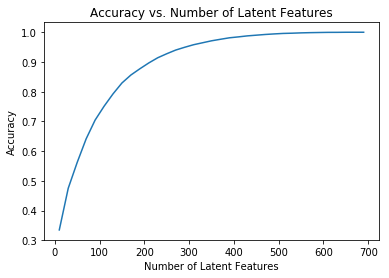

In [64]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [65]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [66]:
#To make predictions for users or articles in the test set, the users or articles must also be present in the training data set. 

test_users_preds = set(test_idx).intersection(list(user_item_train.index))
test_articles_preds = set(test_arts).intersection(list(user_item_train.columns))

print("Users with predictions: ",len(test_users_preds), '\n')
print("Users without predictions: ",len(set(test_idx)) - len(test_users_preds), '\n')
print("Articles with predictions: ",len(test_articles_preds), '\n')
print("Articles without predictions: ",len(set(test_arts)) - len(test_articles_preds))

Users with predictions:  20 

Users without predictions:  662 

Articles with predictions:  574 

Articles without predictions:  0


In [67]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [69]:
# fit SVD on the user_item_train matrix (training data)
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [70]:
user_item_test_subset = user_item_test.loc[test_users_preds, test_articles_preds]

new_user_item_train = user_item_train.reset_index()
users_common_idx = list(new_user_item_train[new_user_item_train['user_id'].isin(test_users_preds)].index)

vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
u_test = u_train[users_common_idx, :]
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [71]:
# How well you can we use the training  decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    # restructure test and train with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test_subset, user_item_est_test)
    
    # total errors and keep track of them
    #train total
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    train_sum_errs.append(err_train)
    
    #test total
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    test_sum_errs.append(err_test)

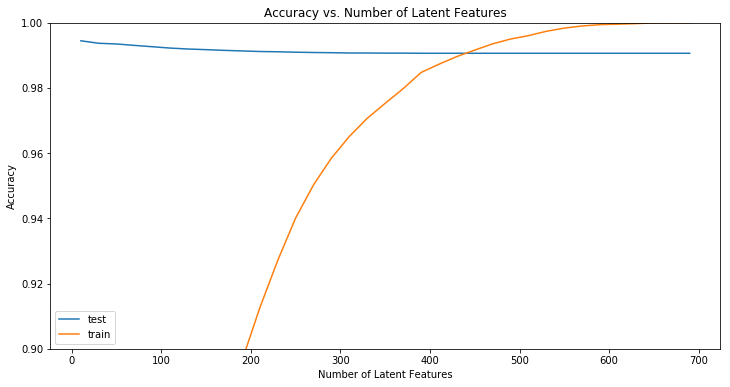

In [72]:
plt.figure(figsize = (12,6))    
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/df.shape[0], label = 'test');
plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/df.shape[0], label = 'train');
plt.ylim(0.9, 1)
plt.xlabel('Number of Latent Features');
plt.legend()
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**We can see that as the number of latent features increases, the test accuracy worsens. This is due to overfitting the SVD on too many features. It is possible to attribute this decreasing accuracy to the low number of common users between our training and test datasets.**

**To determine if any of the recommendation systems above is an improvement to IBM's current recommendation system on the platform, we can run an A/B testing with users in the experiment group getting recommendations from the SVD system above. The metric to gather and consider include article click-rate, reading time, and rating (like/dislike). The users can be easily tracked by their unique user id. A significant increase in user-article interaction for the experiment group over the control group in the same peiod will tell us whether there's an improvement.**

In [73]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0